# Explore TM-Align Results

**TM-Align**

* Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
* Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
* The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)

**RMSD**

* We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. (https://www.mdpi.com/1420-3049/23/5/1038/htm)

# TM-Align Development

In [1]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from multiprocessing import Pool
import random
import pandas as pd

In [2]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(pairs_and_labels, chunk=0):
    '''
    Accepts an n x 3 (query protein, target protein and cluster label) or n x 2 array (query protein and target protein).
    Returns an n x 8 array with original inputs and TM-Align stats for each pair of proteins in the input array. Also writes
    results to pairs_tmalign_rmsd.parquet.
    
    NOTE: The parquet writing is broken at the moment due to multithreading, but the return results is 100% correct, so just
    write your results to file outside this function.
    '''
    result = []
    names = ['query_protein', 'query_protein_length', 'target_protein',
             'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']
    for pair in pairs_and_labels:
        if pair[0] != pair[1]:
            cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
            tmalign_report = os.popen(cmd).readlines()
            result.append(process_report(pair[0], pair[1], tmalign_report))
            if pairs_and_labels.shape[1] > 2:
                result[-1].append(pair[2])
    if pairs_and_labels.shape[1] > 2:
        names.append('cluster')
    chunk = random.randint(0, 100000)
    table = pa.Table.from_pandas(pd.DataFrame(result, columns=names))
    pq.write_table(table, f'tmp/pairs_tmalign_rmsd_{str(chunk)}.parquet')
    return result

In [4]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])

        
#download_file('samples/all_protein_combos_per_cluster.parquet')
#pd.read_parquet('all_protein_combos_per_cluster.parquet').head()

In [ ]:
# test data for functions

combinations = np.array([['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']])
print(tmalign(combinations))

In [12]:
combos = pd.read_parquet('all_protein_combos_per_cluster.parquet')
combos.query_protein = 'AF-' + combos.query_protein.astype(str) + '-F1-model_v1'
combos.target_protein = 'AF-' + combos.target_protein.astype(str) + '-F1-model_v1'
test_combos = combos[['query_protein', 'target_protein', 'cluster']].values

In [ ]:
# SINGLE THREAD (SLOWER)

start = time.time()
answer = tmalign(test_combos)
print(f"took {int(time.time() - start)} seconds")
print(f'Sent {len(test_combos)} records and got back {len(answer)}.')
pd.read_parquet('pairs_tmalign_rmsd_0.parquet').sample(10)

In [ ]:
# OPTIMIZED OVER DEEPFOLD (FASTEST)

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[start::int(size / num_threads)+1] for start in range(int(size / num_threads)+1)]))
    
print(f"took {int(time.time() - start)} seconds")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

table = pa.Table.from_pandas(res)
pq.write_table(table, f'pairs_tmalign_rmsd_merged.parquet')

# TM-Align Production Code

* model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**
* model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**

In [362]:
def load_model(file):
    home = '/home/jupyter/pss/'
    download_file(file)

    model = pd.read_parquet(home + file.split('/')[-1])
    model.query_protein = 'AF-' + model.query_protein.astype(str) + '-F1-model_v1'
    model.target_protein = 'AF-' + model.target_protein.astype(str) + '-F1-model_v1'
    
    batch_stats = pd.read_parquet('pairwise_evaluation_metrics.parquet')
    
    batch_stats.set_index(['query_protein', 'target_protein'], inplace=True)
    model.set_index(['query_protein', 'target_protein'], inplace=True)
    model_stats = model.join(batch_stats, on=['query_protein', 'target_protein'], how='left')
    
    return model_stats.reset_index()

In [441]:
# Get the experiment data

model_stats = load_model('model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet')
model_stats

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q9NU23-F1-model_v1,AF-Q86UA6-F1-model_v1,-1,88.0,219.0,48.0,1.94,0.44014
1,AF-Q9NU23-F1-model_v1,AF-Q6ZNR0-F1-model_v1,-1,88.0,172.0,52.0,3.42,0.40264
2,AF-Q9NU23-F1-model_v1,AF-A0A1B0GUV1-F1-model_v1,-1,88.0,79.0,32.0,2.53,0.30029
3,AF-Q9NU23-F1-model_v1,AF-P15907-F1-model_v1,-1,NaN,NaN,NaN,NaN,NaN
4,AF-Q9NU23-F1-model_v1,AF-Q6P1R3-F1-model_v1,-1,88.0,559.0,65.0,4.73,0.41799
...,...,...,...,...,...,...,...,...
124481,AF-Q9Y3Q3-F1-model_v1,AF-Q9Y3B3-F1-model_v1,1603,217.0,224.0,211.0,1.98,0.91408
124482,AF-Q9Y490-F1-model_v1,AF-Q9Y4G6-F1-model_v1,1604,2541.0,2542.0,1679.0,5.94,0.59108
124483,AF-Q9Y4G6-F1-model_v1,AF-Q9Y490-F1-model_v1,1604,2542.0,2541.0,1679.0,5.94,0.59087
124484,AF-Q9Y6F7-F1-model_v1,AF-Q9Y6F8-F1-model_v1,1605,541.0,540.0,440.0,4.81,0.64983


In [442]:
# Only focus on novel pairs we've never seen to date; also find clusters with more than 200 pairs
test_combos = model_stats[model_stats.rmsd.isna()].reset_index()
x = test_combos.groupby(['cluster']).count().reset_index()
x.drop('index', axis=1, inplace=True)
test_combos.drop('index', axis=1, inplace=True)
big_clusters = x[x.query_protein > 200].cluster.values
big_clusters

array([  -1,    3,   11,   12,   18,   19,   22,   26,   28,   38,   43,
         44,   46,   63,   90,  101,  102,  107,  110,  113,  116,  121,
        130,  147,  149,  151,  155,  189,  247,  254,  281,  283,  318,
        329,  333,  335,  340,  341,  350,  353,  367,  373,  407,  441,
        444,  465,  473,  476,  480,  604,  670,  721,  738,  779,  830,
        831,  899,  969, 1092, 1148, 1209, 1296, 1357, 1569])

In [443]:
# Downsample big clusters (> 200 pairs) to 25%
big_cluster_samples = pd.DataFrame(None, columns=x.columns)

for cluster in big_clusters:
    sliced = test_combos[test_combos.cluster == cluster]
    big_cluster_samples = big_cluster_samples.append(sliced.sample(int(len(sliced) * 0.25)))

big_cluster_samples.head()

,cluster,query_protein,target_protein,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
2178,-1,AF-Q8IWX8-F1-model_v1,AF-Q8IWT0-F1-model_v1,NaN,NaN,NaN,NaN,NaN
1134,-1,AF-Q14147-F1-model_v1,AF-Q9P0P8-F1-model_v1,NaN,NaN,NaN,NaN,NaN
1825,-1,AF-Q5GH72-F1-model_v1,AF-Q8TD17-F1-model_v1,NaN,NaN,NaN,NaN,NaN
2990,-1,AF-Q96K19-F1-model_v1,AF-Q6P1R3-F1-model_v1,NaN,NaN,NaN,NaN,NaN
914,-1,AF-P27824-F1-model_v1,AF-Q92563-F1-model_v1,NaN,NaN,NaN,NaN,NaN


In [444]:
# Recombine small clusters with big cluster samples
test_combos = test_combos[~test_combos.cluster.isin(big_clusters)].append(big_cluster_samples)
test_combos.head()

,query_protein,target_protein,cluster,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
29858,AF-O75147-F1-model_v1,AF-Q5VST9-F1-model_v1,471,NaN,NaN,NaN,NaN,NaN
29859,AF-Q5VST9-F1-model_v1,AF-O75147-F1-model_v1,471,NaN,NaN,NaN,NaN,NaN
29947,AF-O95714-F1-model_v1,AF-Q15751-F1-model_v1,553,NaN,NaN,NaN,NaN,NaN
29948,AF-Q15751-F1-model_v1,AF-O95714-F1-model_v1,553,NaN,NaN,NaN,NaN,NaN
30344,AF-P50851-F1-model_v1,AF-Q8NFP9-F1-model_v1,957,NaN,NaN,NaN,NaN,NaN


In [445]:
# generate array for tmalign
test_combos = test_combos.values
len(test_combos)

22934

In [446]:
# remove pairs with known giant protein
known_giant_proteins = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/merged_pdbs/')]
zmp = []
for pair in test_combos:
    if pair[0] in known_giant_proteins or pair[1] in known_giant_proteins:
        continue
    else:
        zmp.append(pair)
test_combos = np.array(zmp)
len(test_combos)

19272

In [ ]:
# run tmalign and save chunked results to parquet files

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
step = 25
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[i*step:(i+1)*step] for i in range(int(size / step + 1))]))
    
print(f"Took {int((time.time() - start) / 60)} minutes.")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(5)

# Analysis

* model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
* model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet
* model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet
* model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet

Clusters: 1606
Pairs: 124486
Nulls: 43702
Noise: 9900


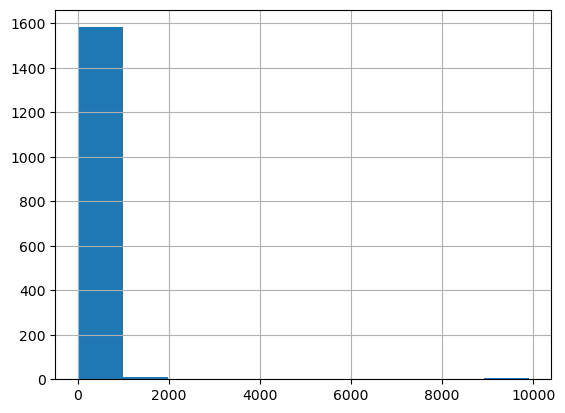

In [457]:
experiments = [['SeqVec', 'DBSCAN'], ['SeqVec', 'HDBSCAN'], ['DeepFold', 'DBSCAN'], ['DeepFold', 'HDBSCAN']]

model_stats = load_model(f'model_outputs/A2-{experiments[0][1]}-{experiments[0][0]}-all_protein_combos_per_cluster.parquet')
name = f"{experiments[0][0]} + {experiments[0][1]}"

print('Clusters:', len(model_stats.cluster.unique()))
print('Pairs:', len(model_stats))
print('Nulls:', len(model_stats[model_stats.rmsd.isna()]))
print('Noise:', len(model_stats[model_stats.cluster == -1]))

model_stats[['cluster', 'query_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['query_protein'], ascending=False).query_protein.hist();

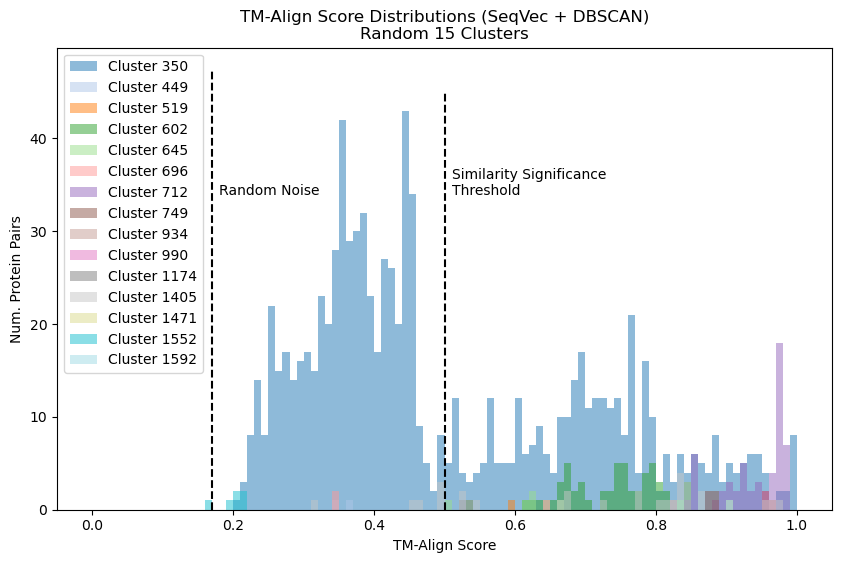

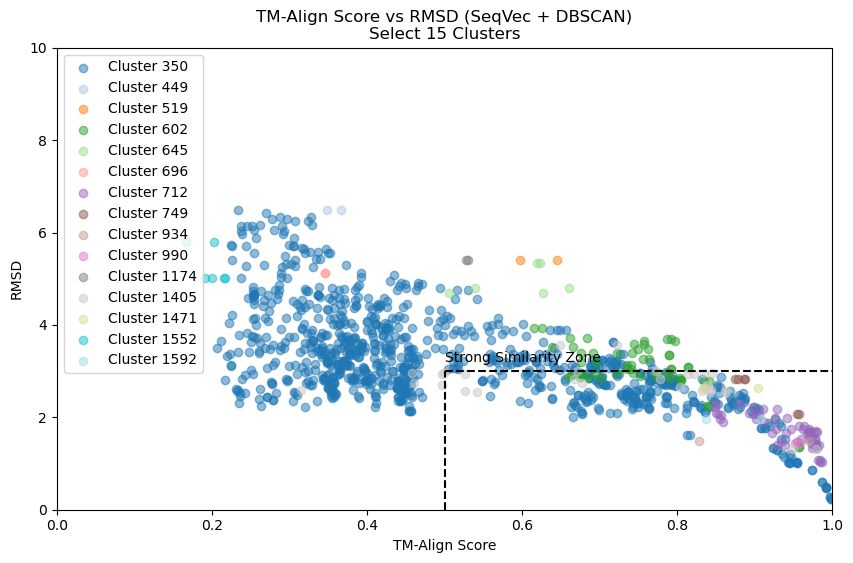

In [458]:
from utils import model_and_evaluate_cluster as ev

cmap = 'tab20'
plot_1_clusters = ev.tmalign_hist(model_stats, version='random', num_results=15, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(model_stats[model_stats.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [ ]:
# TODO: handle clusters with no scores
# BUT ALSO: I don't think this is a very relevant or even correct test. Can and should probably be ignored.
# import scipy.stats as st

# tmalign_stats_agg = pd.DataFrame(None, columns=['cluster', 'cl', 'ci', 'spread'])
# alpha = 0.98

# for cluster in model_stats.cluster.unique():
#     data = model_stats[(~model_stats.tmalign_score.isna()) & (model_stats.cluster == cluster)]
#     ci = st.norm.interval(alpha=alpha, loc=np.mean(data.tmalign_score.values), scale=st.sem(data.tmalign_score.values))
#     tmalign_stats_agg.loc[len(tmalign_stats_agg.index)] = [cluster, alpha, ci, ci[1] - ci[0]]
# print(f'{name}: Num. Clusters by Confidence Interval Spread\n{len(tmalign_stats_agg)} Clusters Evaluated')
# tmalign_stats_agg.spread.hist(bins=25);

# Add BLAST Stats & Explore

In [459]:
blast = pd.read_parquet('blast_annotations_agg.parquet')
blast.set_index(['query_protein', 'target_protein'], inplace=True)
model_stats_expanded = model_stats.set_index(['query_protein', 'target_protein']).join(blast, on=['query_protein', 'target_protein'], how='left')
model_stats_expanded

cluster  query_protein_length  \
query_protein         target_protein                                         
AF-Q86UA6-F1-model_v1 AF-Q9H1M3-F1-model_v1       -1                   NaN   
                      AF-Q9BXF9-F1-model_v1       -1                   NaN   
                      AF-Q9NV92-F1-model_v1       -1                   NaN   
                      AF-Q9Y394-F1-model_v1       -1                   NaN   
                      AF-Q6P2I7-F1-model_v1       -1                   NaN   
...                                              ...                   ...   
AF-Q9Y3Q3-F1-model_v1 AF-Q9Y3B3-F1-model_v1     1603                 217.0   
AF-Q9Y490-F1-model_v1 AF-Q9Y4G6-F1-model_v1     1604                2541.0   
AF-Q9Y4G6-F1-model_v1 AF-Q9Y490-F1-model_v1     1604                2542.0   
AF-Q9Y6F7-F1-model_v1 AF-Q9Y6F8-F1-model_v1     1605                 541.0   
AF-Q9Y6F8-F1-model_v1 AF-Q9Y6F7-F1-model_v1     1605                 540.0   

                                             target_protein_length  \
query_protein         target_protein                                 
AF-Q86UA6-F1-model_v1 AF-Q9H1M3-F1-model_v1                    NaN   
                      AF-Q9BXF9-F1-model_v1                    NaN   
                      AF-Q9NV92-F1-model_v1                    NaN   
                      AF-Q9Y394-F1-model_v1                    NaN   
                      AF-Q6P2I7-F1-model_v1                    NaN   
...                                                            ...   
AF-Q9Y3Q3-F1-model_v1 AF-Q9Y3B3-F1-model_v1                  224.0   
AF-Q9Y490-F1-model_v1 AF-Q9Y4G6-F1-model_v1                 2542.0   
AF-Q9Y4G6-F1-model_v1 AF-Q9Y490-F1-model_v1                 2541.0   
AF-Q9Y6F7-F1-model_v1 AF-Q9Y6F8-F1-model_v1                  540.0   
AF-Q9Y6F8-F1-model_v1 AF-Q9Y6F7-F1-model_v1                  541.0   

                                             aligned_length  rmsd  \
query_protein         target_protein                                
AF-Q86UA6-F1-model_v1 AF-Q9H1M3-F1-model_v1             NaN   NaN   
                      AF-Q9BXF9-F1-model_v1             NaN   NaN   
                      AF-Q9NV92-F1-model_v1             NaN   NaN   
                      AF-Q9Y394-F1-model_v1             NaN   NaN   
                      AF-Q6P2I7-F1-model_v1             NaN   NaN   
...                                                     ...   ...   
AF-Q9Y3Q3-F1-model_v1 AF-Q9Y3B3-F1-model_v1           211.0  1.98   
AF-Q9Y490-F1-model_v1 AF-Q9Y4G6-F1-model_v1          1679.0  5.94   
AF-Q9Y4G6-F1-model_v1 AF-Q9Y490-F1-model_v1          1679.0  5.94   
AF-Q9Y6F7-F1-model_v1 AF-Q9Y6F8-F1-model_v1           440.0  4.81   
AF-Q9Y6F8-F1-model_v1 AF-Q9Y6F7-F1-model_v1           440.0  4.81   

                                             tmalign_score  hit_span_mean  \
query_protein         target_protein                                        
AF-Q86UA6-F1-model_v1 AF-Q9H1M3-F1-model_v1            NaN            NaN   
                      AF-Q9BXF9-F1-model_v1            NaN            NaN   
                      AF-Q9NV92-F1-model_v1            NaN            NaN   
                      AF-Q9Y394-F1-model_v1            NaN            NaN   
                      AF-Q6P2I7-F1-model_v1            NaN            NaN   
...                                                    ...            ...   
AF-Q9Y3Q3-F1-model_v1 AF-Q9Y3B3-F1-model_v1        0.91408          194.0   
AF-Q9Y490-F1-model_v1 AF-Q9Y4G6-F1-model_v1        0.59108         2540.0   
AF-Q9Y4G6-F1-model_v1 AF-Q9Y490-F1-model_v1        0.59087         2540.0   
AF-Q9Y6F7-F1-model_v1 AF-Q9Y6F8-F1-model_v1        0.64983          540.0   
AF-Q9Y6F8-F1-model_v1 AF-Q9Y6F7-F1-model_v1        0.65088          541.0   

                                             bitscore_mean    evalue_mean  
query_protein         target_protein                                       
AF-Q86UA6-F1-model_v1 AF-Q9H1M3-F1-model_v1            NaN         

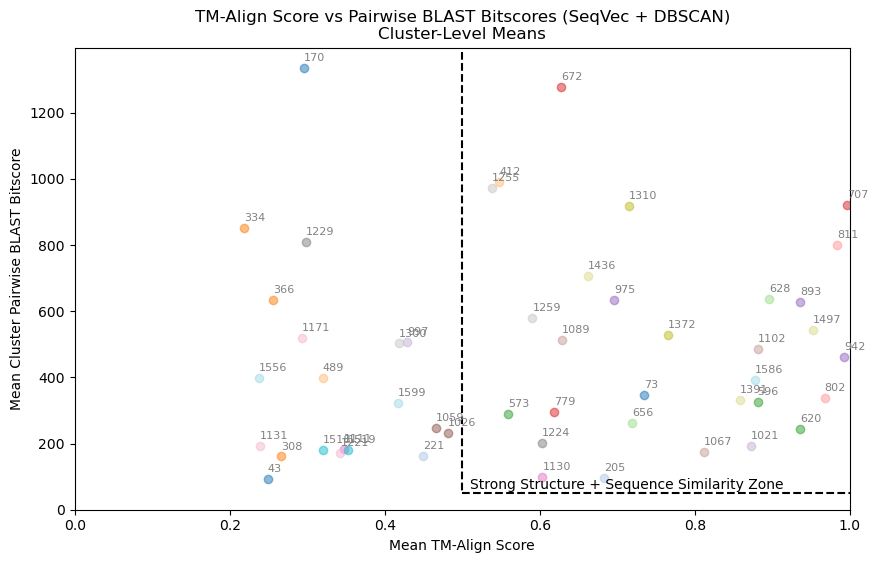

In [460]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

t = model_stats_expanded[~model_stats_expanded.rmsd.isna() & ~model_stats_expanded.bitscore_mean.isna()][['cluster', 'tmalign_score', 'bitscore_mean']].groupby(['cluster']).mean().reset_index()
t = t[t.cluster.isin(t.cluster.sample(50))]

cmap='tab20'
figure(figsize=(10, 6))
pyplot.style.use('default')
colors = pyplot.get_cmap(cmap, len(t))

for i, cluster in enumerate(t.values):
    pyplot.scatter(x=cluster[1], y=cluster[2], alpha=0.5, color=colors(i), label=f'Cluster {int(cluster[0])}')
    pyplot.annotate(int(cluster[0]), # this is the text
                 (cluster[1],cluster[2]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='left',
                   fontsize=8., color='grey') # horizontal alignment can be left, right or center
#pyplot.legend(loc='upper left')

pyplot.xlim(left=0, right=1)
pyplot.ylim(bottom=0)
pyplot.vlines(0.5, t.bitscore_mean.max() +50, 50, linestyles='dashed', colors='k')
pyplot.hlines(50, 0.5, 1, linestyles='dashed', colors='k')
pyplot.text(0.51, 64, 'Strong Structure + Sequence Similarity Zone')
pyplot.xlabel('Mean TM-Align Score')
pyplot.ylabel('Mean Cluster Pairwise BLAST Bitscore')
pyplot.title(f'TM-Align Score vs Pairwise BLAST Bitscores ({name})\nCluster-Level Means')
pyplot.show();

In [461]:
t = model_stats_expanded[~model_stats_expanded.rmsd.isna() & ~model_stats_expanded.bitscore_mean.isna()][['cluster', 'tmalign_score', 'bitscore_mean', 'rmsd']].groupby(['cluster']).mean().reset_index()
z = t[t.bitscore_mean > 50]
z = z[z.tmalign_score > 0.5]
z = z[z.rmsd < 3.]
print(name.upper())
print(f'Percent clusters in S4 Zone intersect S2 Zone:', round(len(z) / len(t), 4))
tmp = model_stats_expanded[~model_stats_expanded.rmsd.isna() & ~model_stats_expanded.bitscore_mean.isna()]
print(f'Percent protein pairs in S4 Zone intersect S2 Zone:', round(len(tmp[tmp.cluster.isin(z.cluster.unique())]) / len(tmp), 4))
print('Noise Ratio:', round(len(model_stats_expanded[model_stats_expanded.cluster == -1]) / len(model_stats_expanded[~model_stats_expanded.tmalign_score.isna()]), 4))
print('TM-Align score coverage:', round(len(model_stats_expanded[~model_stats_expanded.rmsd.isna()]) / len(model_stats_expanded), 4))


SEQVEC + DBSCAN
Percent clusters in S4 Zone intersect S2 Zone: 0.4356
Percent protein pairs in S4 Zone intersect S2 Zone: 0.3923
Noise Ratio: 0.1225
TM-Align score coverage: 0.6489


## Experiment-Level Metrics

**S2** represents the Strong Similarity zone, where TM-Align > 0.5 and RMSD < 3.

**S4** represents the Strong Structure + Sequence Similarity zone, where TM-Align > 0.5 and Bitscore > 50.

|Pct. S4 $\bigcap$ S2|SeqVec + HDBSCAN|DeepFold + DBSCAN|SeqVec + DBSCAN|DeepFold + HDBSCAN|
|--------------------|            ---:|             ---:|           ---:|              ---:|
|Clusters            |          0.3419|           0.2051|     **0.4356**|            0.1333|
|Protein Pairs       |      **0.3972**|           0.0613|         0.3923|            0.0674|
|Noise Ratio         |            0.0?|             0.0?|     **0.1225**|            0.1232|
|TM-Align Coverage   |          0.7629|       **0.9934**|         0.6489|            0.6453|

**Questions**
1. Is the noise ration 0.0 for SeqVec + HDBSCAN and DeepFold + DBSCAN because the data already excludes the noise cluster? Is the noise cluster always -1 for all models?

**Insights**
1. We can stop mining DeepFold + DBSCAN pairs. TM-Align Coverage is almost 100% and other metrics are terrible. DeepFold + HDBSCAN Coverage is the lowest of the bunch, however even so the metrics are so much lower than the SeqVec models, we should probably just focus additional TM-Align runs on SeqVec models. Right now between the two of those, we have very similar Coverage and while the % clusters in S4 $\bigcap$ S2 is 9% higher in the DBSCAN model, the proportion of Protein Pairs is marginally higher in HDBSCAN. Thus it may make sense to increase coverage for both to see if the metrics start to favor just one, or continue to diverge, indicating 2 possible solid choices. See caveat re: Noise Ratio for these 2 models above.